## Initialisation

In [9]:
!pip install keras

    100% |################################| 337kB 3.2MB/s eta 0:00:01
    100% |################################| 256kB 4.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import keras
import h5py as h5
import numpy as np

PATH_DATA = 'half.h5'
PATH_PREDICT_WITHOUT_GT = 'pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = 'pred_eighties_from_half_1_INCREDIBLE.csv'
PATH_PREDICT_WITH_GT = 'pred_eighties_from_half_1.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## CNN

In [11]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, MaxPooling2D, ZeroPadding2D
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [12]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [96]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

def generator_feat(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True :
        X = np.zeros((batch_size, 8))
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X1_temp = np.array(f['S2'][batch_idxs, :,:,:])
            X1 = np.mean(X1_temp, axis=(1,2))
            X2 = np.std(np.array(f['S2'][batch_idxs, :,:,:]), axis=(1,2))
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            X[:, :4] = X1
            X[:, 4:] = X2
            yield X, keras.utils.np_utils.to_categorical(np.array(Y), 23)
def generator_rf(h5_path, idxs):
    f = h5.File(h5_path, 'r')
    X = np.zeros(8)
    X1_temp = np.array(f['S2'][idxs, :,:,:])
    #print("X1_temp=",X1_temp)
    X1 = np.mean(X1_temp, axis=(0,1))
    #print("X1=",X1)
    X2 = np.std(X1_temp, axis=(0,1))
    #print("X2=",X2)
    y = f['TOP_LANDCOVER'][idxs, :]
    #print(Y)
    X[:4] = X1
    X[4:] = X2
    #print("X=",X)
    return X, y[0]          
def get_category(h5_path, idxs):
    f = h5.File(h5_path, 'r')
    categories = [0 for x in range(23)]
    Y = f['TOP_LANDCOVER'][sorted(idxs), :]
    for lbl in Y:
        categories[lbl] += 1
    return categories

In [97]:
print(generator_rf(PATH_DATA,5))

(array([319.6875    , 570.16796875, 898.578125  , 189.33984375,
        15.08763504,  13.71153641,  14.45583439,  15.17394829]), 20.0)


In [107]:
PATH_DATA = 'half.h5'
idxs = get_idxs(PATH_DATA)
print(idxs)
X_train = []
y_train = []
for i in range(idxs[1000]):
    X,y = generator_rf(PATH_DATA,i)
    X_train.append(X)
    y_train.append(y)

range(0, 9349120)


In [70]:
train_gen = generator_feat(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator_feat(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [73]:
print(generator_rf(PATH_DATA,5))

ValueError: could not broadcast input array from shape (4) into shape (1,8)

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 4, 
                            min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', 
                            bootstrap = True, oob_score = True, n_jobs = 1, random_state = None, verbose = True)  

In [59]:
rf = rf.fit(train_gen,val_gen)

TypeError: float() argument must be a string or a number, not 'generator'

In [76]:
input_shape = (16,16,4)
dropout_rate = 0.5

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=input_shape))
model.add(Conv2D(4,(3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(4, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(23, activation='softmax'))

In [78]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=10, verbose=1, validation_data=val_gen, nb_val_samples=100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, validation_steps=100, epochs=10, validation_data=<generator..., steps_per_epoch=100)`
  


Epoch 1/10
100/100 [==============================] - 300s 3s/step - loss: 3.8118 - acc: 0.2375 - val_loss: 1.7062 - val_acc: 0.4550
Epoch 2/10
100/100 [==============================] - 288s 3s/step - loss: 1.8527 - acc: 0.3709 - val_loss: 1.5554 - val_acc: 0.4956
Epoch 3/10
100/100 [==============================] - 273s 3s/step - loss: 1.6868 - acc: 0.4213 - val_loss: 1.5237 - val_acc: 0.4725
Epoch 4/10
100/100 [==============================] - 271s 3s/step - loss: 1.6230 - acc: 0.4503 - val_loss: 1.4519 - val_acc: 0.4969
Epoch 5/10
100/100 [==============================] - 260s 3s/step - loss: 1.5177 - acc: 0.4841 - val_loss: 1.4648 - val_acc: 0.4891
Epoch 6/10
100/100 [==============================] - 262s 3s/step - loss: 1.4830 - acc: 0.4928 - val_loss: 1.3954 - val_acc: 0.5209
Epoch 7/10
100/100 [==============================] - 261s 3s/step - loss: 1.5250 - acc: 0.4725 - val_loss: 1.3711 - val_acc: 0.5325
Epoch 8/10
100/100 [==============================] - 264s 3s/step - 

In [79]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [80]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700
7554/7554 [==============================] - 29s 4ms/step
241700


1

In [81]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [82]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

Normalized confusion matrix


<IPython.core.display.Javascript object>


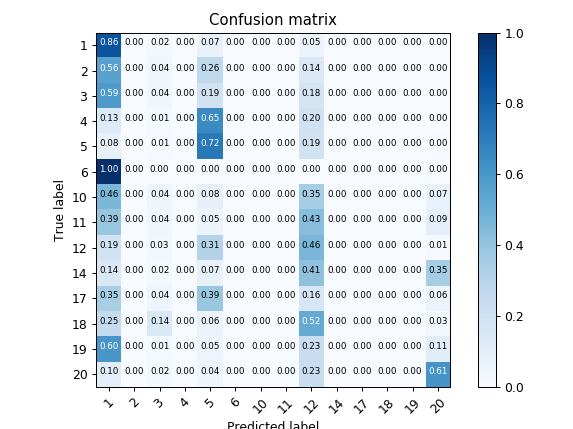

In [84]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)

In [85]:
somme = 0
for i in range (len(real_cnf_matrix)):    
    somme = somme + real_cnf_matrix[i,i] 
somme_t = sum(sum(real_cnf_matrix))
somme/somme_t

0.5226272238311956

In [86]:
model.save("incredible_florian.dqf")

In [87]:
ls


5tars-and-a-friend/      incredible_florian.dqf
Hackathon.ipynb          launch_verif_from_students_pred.py
Hackathon_Florian.ipynb  pred_eighties_from_half_1.h5
data/                    pred_eighties_from_half_1_AWESOMEGROUP.h5
eightieth.h5             pred_eighties_from_half_1_without_gt.h5
half.h5


In [ ]:
df2 = pd.DataFrame(y_pred, columns=['TOP_LANDCOVER'])
df2.to_csv(PATH_SUBMIT, index="ID")